# CE7454 Project: Movie Rateing and Box-office Prediction

*Group 26: Li Jie, Shen Meng, Wang Ruihang*

Welcome to the our project! In this work, we are going to save the viewers and producers from the ocean of movies. Our job is to give a reliable prediction of a movies's rating and box-office before its theatrical release, aiming to offer useful information in an early stage. 

**In this project, we will:**
- Crawl and build our dataset from [IMDB](https://www.imdb.com)
- Clean and present the raw data for analysis
- Apply different models for movie rating and box-office prediction
- Propose our new architecture for further improvement
- Compare and analyze the results of each method

<table>

<img src="images/posters.png" style="width:800;height:300px;">

</table>

Run the following cell to load the packages and dependencies that are going to be useful for our project.

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
sys.path.append('../model')
sys.path.append('../model/rating_model')
from Baseline.net.vanilla import *
from Baseline.net.resnet import *
from matplotlib.pyplot import imshow
from torch.utils import data
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import seaborn as sns


%matplotlib inline

**Note**: We use the open source deep learning library [Pytorch](https://pytorch.org) to build our models

## 1 - Web Scraping for Dataset

IMDb provides an available dataset for personal and non-commercial use which includes some basic information of all kinds of videos, for example tv shows, shorts, dramas and etc.

The dataset is available here: https://datasets.imdbws.com.

### 1.1 Download Exsiting Dataset

If you want to reproduce the code, please download and extract the following dataset, and put it into the `data` folder.

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.crew.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz

### 1.2 ( Important ! )To get the final training data "imdb.tsv" file

* You can run the [data_clean.ipynb]('data_clean.ipynb') to clean the raw dataset found on imdb.com and [spider.py](../crawler/spider.py) file to obtain extra data like **box-office, actors, storyline**.
* Or you can directly download the [imdb.tsv](https://github.com/pupboss/CE7454-Project-Fall2019/blob/master/data/imdb.tsv) file on github which has been cleaned

After that, you will get the final dataset named `imdb.tsv` which will be our training and validating dataset and put it into the `data` folder.

## 2 - Preprocessing and Visualization

In this section, we investigate the impact of different variables on movie rating and box-office revenues. The data we crawled from Internet contains list of movie's information, such as budget, duration, genres, actors, directors, writers, story line, poster and its corresponding rating and box-office. Through preprocessing, the variables can be categorized as three types: *numerical data, vector data and image data*

- **Budget**: Budget is a numerical number that represents the financial investment in a movie
- **Duration**: Duration(Run Time) is a numerical number that defines the running time of a movie
- **Year**: Year is a numerical number that reveals the production time
- **Genres**: Movie genre is vector data with corresponding position set to one for a movie belongs to and others to zeros
- **Story line**: Story line is a word vector data that contains brief introduction of the movie
- **Poster**: Movie poster is a image data that contains potential information to exploit

### 2.1 Pre-processing for Box-office Prediction

You can refer to data_clean.ipynb for pre_processing part.

### 2.2 Visualization

In [55]:
imdb = pd.read_csv('../data/imdb.tsv', sep='\t')
imdb

,tconst,Budget,Box_Office,Star_1,Star_2,Star_3,Star_num1,Star_num2,Star_num3,primaryTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,Story_Line,Ratio,Profitable
0,tt0035423,48000000,76019048,Meg Ryan,Hugh Jackman,Liev Schreiber,nm0000212,nm0413168,nm0000630,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",nm0003506,"nm0737216,nm0003506",6.4,75027,Kate and her actor brother live in N.Y. in the...,1.583730,True
1,tt0118589,22000000,5271666,Mariah Carey,Eric Benét,Max Beesley,nm0001014,nm0073160,nm0066586,Glitter,2001,104,"Drama,Music,Romance",nm0193554,"nm0921985,nm0486824",2.2,20922,"Billie Frank is a shy, young multiracial girl ...",0.239621,False
2,tt0120467,120000,15927,Brian O'Halloran,Bryan Johnson,Jerry Lewkowitz,nm0641168,nm0424682,nm0507915,Vulgar,2000,87,"Crime,Drama,Thriller",nm0424682,nm0424682,5.3,3840,"A loser with a crummy apartment, an odious mot...",0.132724,False
3,tt0120630,45000000,224834564,Mel Gibson,Julia Sawalha,Phil Daniels,nm0000154,nm0768018,nm0200057,Chicken Run,2000,84,"Adventure,Animation,Comedy","nm0661910,nm0520485","nm0520485,nm0661910,nm0456732,nm0123666,nm0640976",7.0,166546,Having been hopelessly repressed and facing ev...,4.996324,True
4,tt0120667,100000000,330120875,Ioan Gruffudd,Michael Chiklis,Chris Evans,nm0344435,nm0004821,nm0262635,Fantastic Four,2005,106,"Action,Adventure,Fantasy",nm1103162,"nm0004111,nm0289833,nm0498278,nm0456158",5.7,300227,"Reed Richards, a brilliant but timid and bankr...",3.301209,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,tt9037222,1200000,2708622,Vladimir Zelenskiy,Anastasiya Korotkaya,Evgeniy Koshevoy,nm3305952,nm8701109,nm4915252,"Ya, Ty, Vin, Vona",2018,96,Comedy,"nm3305952,nm0230279","nm10366448,nm0230279,nm7928520,nm3424663,nm342...",5.3,237,"A married couple decides to divorce, but thing...",2.257183,True
6570,tt9095324,3207695,812524,Guy Berryman,Beyoncé,Jon Buckland,nm1363068,nm0461498,nm1363136,Coldplay: A Head Full of Dreams,2018,115,"Documentary,Music",nm1475971,\N,8.0,2064,A HEAD FULL OF DREAMS offers an in-depth and i...,0.253305,False
6571,tt9203168,1517700,904513,Horatiu Malaele,Iosif Pastina,Dana Dogaru,nm0538855,nm3844603,nm0230483,Moromete Family: On the Edge of Time,2018,110,Drama,nm0347720,"nm0347720,nm0695737",7.7,1186,A sequel to Romanian cinema's best-known famil...,0.595976,False
6572,tt9272138,397949,22337,Jianjun Ding,Bo Dong,Shuilin Long,nm10705955,nm10705956,nm10705957,Out of Crimes,2018,91,Crime,nm10255953,nm10255953,4.9,11,Miner Junpo's daughter is seriously ill and ne...,0.056130,False


In [56]:
imdb.describe()

,Budget,Box_Office,startYear,runtimeMinutes,averageRating,numVotes,Ratio
count,6.574000e+03,6.574000e+03,6574.000000,6574.000000,6574.000000,6.574000e+03,6574.000000
mean,2.332319e+07,5.709340e+07,2009.414055,105.486158,6.182142,5.714091e+04,1.649873
std,3.762667e+07,1.409524e+08,5.013582,17.934929,1.083073,1.257116e+05,1.896514
min,1.000000e+04,5.810000e+02,2000.000000,60.000000,1.100000,5.000000e+00,0.050021
25%,2.000000e+06,8.024778e+05,2006.000000,93.000000,5.600000,1.110250e+03,0.275076
50%,8.000000e+06,5.760734e+06,2009.000000,102.000000,6.300000,9.132500e+03,0.922394
75%,2.700000e+07,4.455495e+07,2014.000000,115.000000,6.900000,5.498250e+04,2.331832
max,3.210000e+08,2.048360e+09,2018.000000,180.000000,9.100000,2.111245e+06,9.985523


#### We can see that 48.1 percent of movies are profitable.

percentage of profitable movies: 48.1 


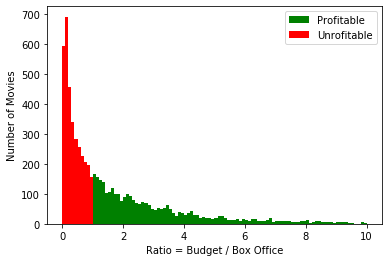

In [92]:
print("percentage of profitable movies: %0.1f " % float((imdb['Ratio']>1).sum() / len(imdb) * 100))
plt.hist(imdb[imdb['Ratio']>1]['Ratio'].to_numpy(), bins=100, range=(0,10), color='green',label='Profitable')
plt.hist(imdb[imdb['Ratio']<=1]['Ratio'].to_numpy(), bins=100, range=(0,10), color='red',label='Unrofitable')
plt.legend()
plt.xlabel("Ratio = Budget / Box Office")
plt.ylabel("Number of Movies")
plt.show()

### Most of the movies' rating are around 7

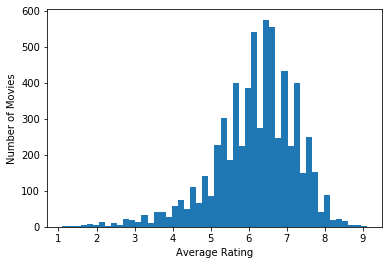

In [90]:
plt.hist(imdb["averageRating"],bins=50)
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.show()

### Relation between Rating and whether Profitable

Profitalbe Movies' Average Rating is **6.3** which is slightly higher than unprofitable movies' average rating **6.0**

Profitable Movies' Average Rating: 6.349
Unprofitable Movies' Average Rating: 6.028


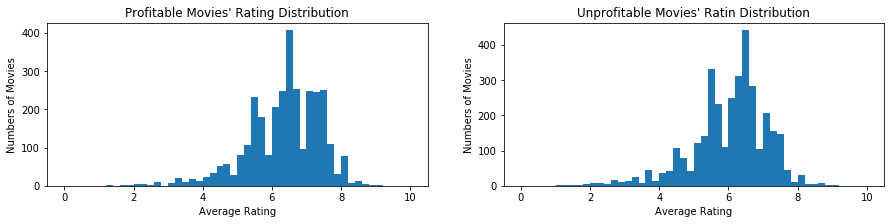

In [79]:
print("Profitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']>1]['averageRating'].sum() / (imdb['Ratio']>1).sum()))
print("Unprofitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']<=1]['averageRating'].sum() / (imdb['Ratio']<=1).sum()))
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(imdb[imdb['Ratio']>1]['averageRating'].to_numpy(), bins=50, range=(0,10))
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Profitable Movies' Rating Distribution")

plt.subplot(122)
plt.hist(imdb[imdb['Ratio']<1]['averageRating'].to_numpy(), bins=50, range=(0,10))
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Unprofitable Movies' Ratin Distribution")
plt.show()


### Genre

Different movie genre may has potential relation to average rating and box office

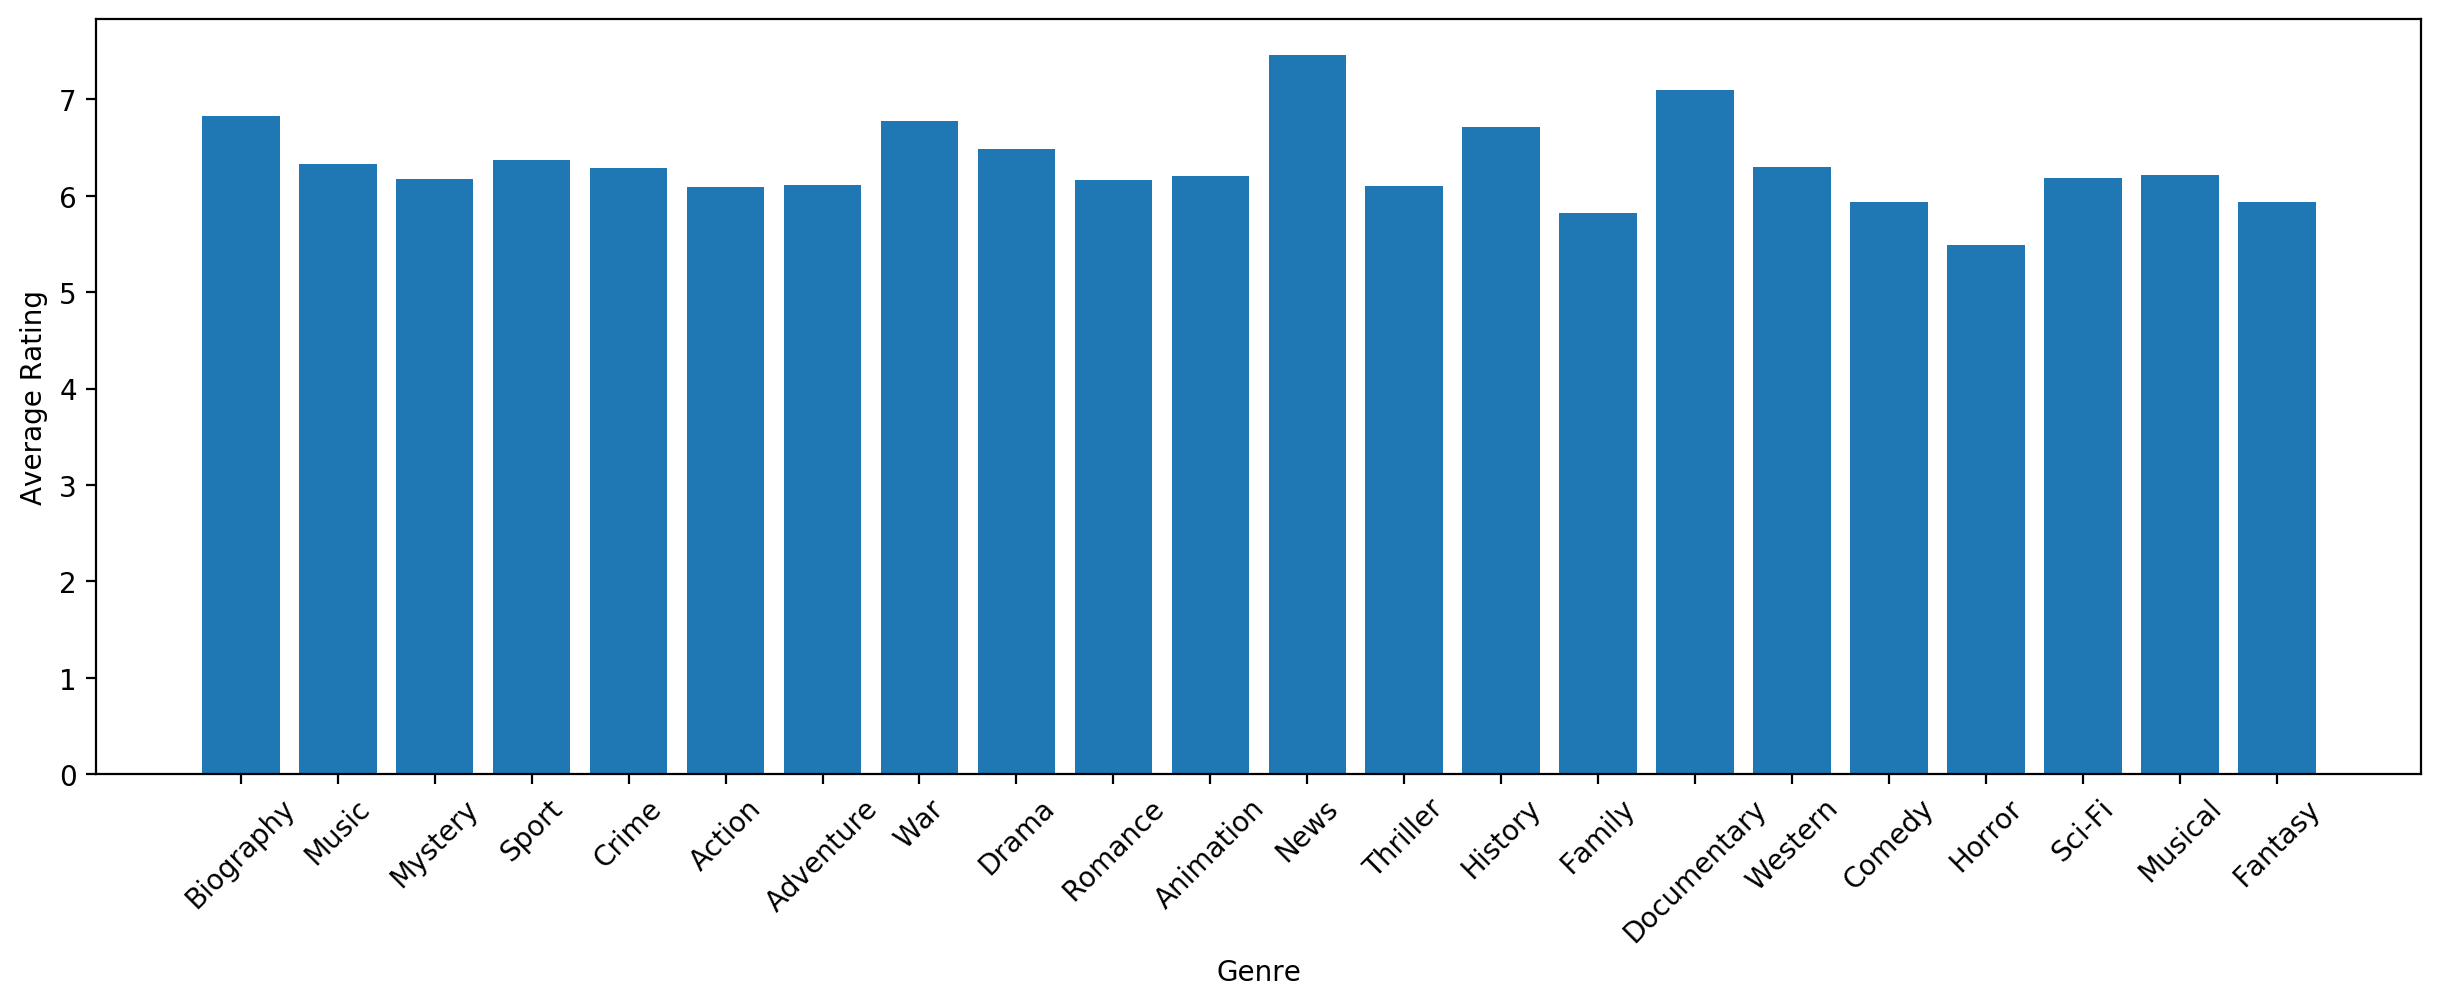

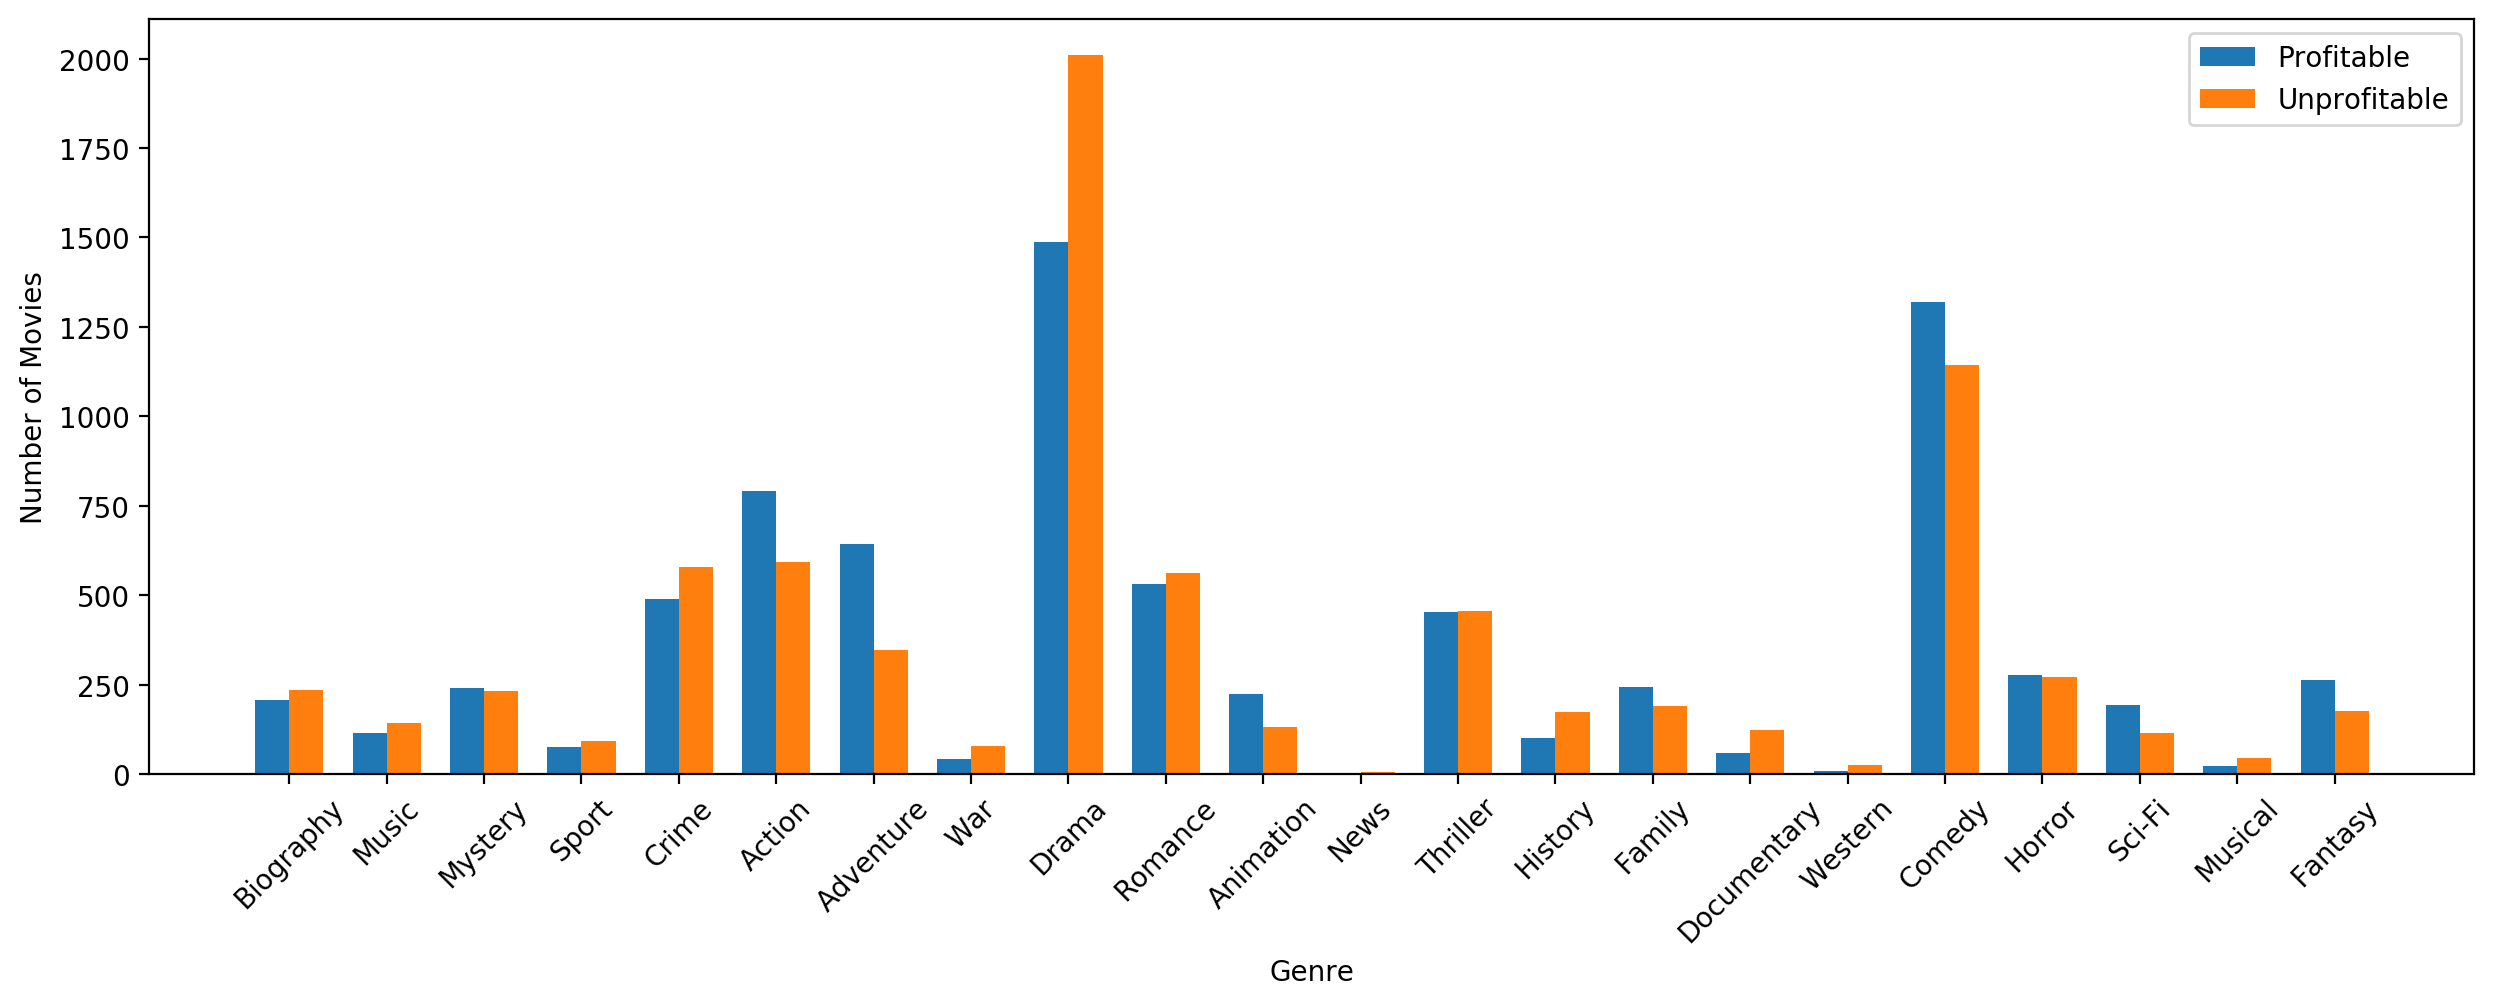

In [60]:
genre_set = set()
for row in imdb.iterrows():
    for each in row[1]['genres'].split(','):
        if each != "\\N":
            genre_set.add(each)
genre_rating_group = {}

for each_genre in genre_set:
    genre_rating = imdb[imdb['genres'].str.contains(each_genre)]['averageRating'].sum()
    genre_num = (imdb['genres'].str.contains(each_genre)).sum()
    genre_rating_group[each_genre] = genre_rating / genre_num

plt.figure(dpi=200,figsize=(15,5))
plt.bar(range(len(genre_set)), [genre_rating_group.get(x) for x in genre_set])
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

genre_ratio_group = {}
for each_genre in genre_set:
    genre_ratio_positive = imdb[imdb['genres'].str.contains(each_genre)]['Profitable'].sum()
    genre_num = (imdb['genres'].str.contains(each_genre)).sum()
    genre_ratio_negative = genre_num - genre_ratio_positive
    genre_ratio_group[each_genre] = (genre_ratio_positive, genre_ratio_negative)

x = np.arange(len(genre_set))
width = 0.35
plt.figure(dpi=200,figsize=(15,5))
plt.bar(x - width/2, [genre_ratio_group.get(x)[0] for x in genre_set], width, label="Profitable")
plt.bar(x + width/2, [genre_ratio_group.get(x)[1] for x in genre_set], width, label="Unprofitable")
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

### Year

from the image below, we can see that the movies of **2011** may have a lower rating than other years'.

In [6]:
year_rating = []
for year in range(2000,2019):
    rating = imdb[imdb['startYear'] == year]['averageRating'].sum() 
    movie_num = (imdb['startYear'] == year).sum()
    rating /= movie_num
    year_rating.append(rating)

plt.figure(figsize=(15,3),dpi=200)
plt.plot(range(2000,2019), year_rating)
plt.xticks(list(range(2000,2019)), rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()

NameError: name 'imdb' is not defined

From the image below, we can see that there are more unprofitable movies than profitable movies in some years like **2007** and **2009**.

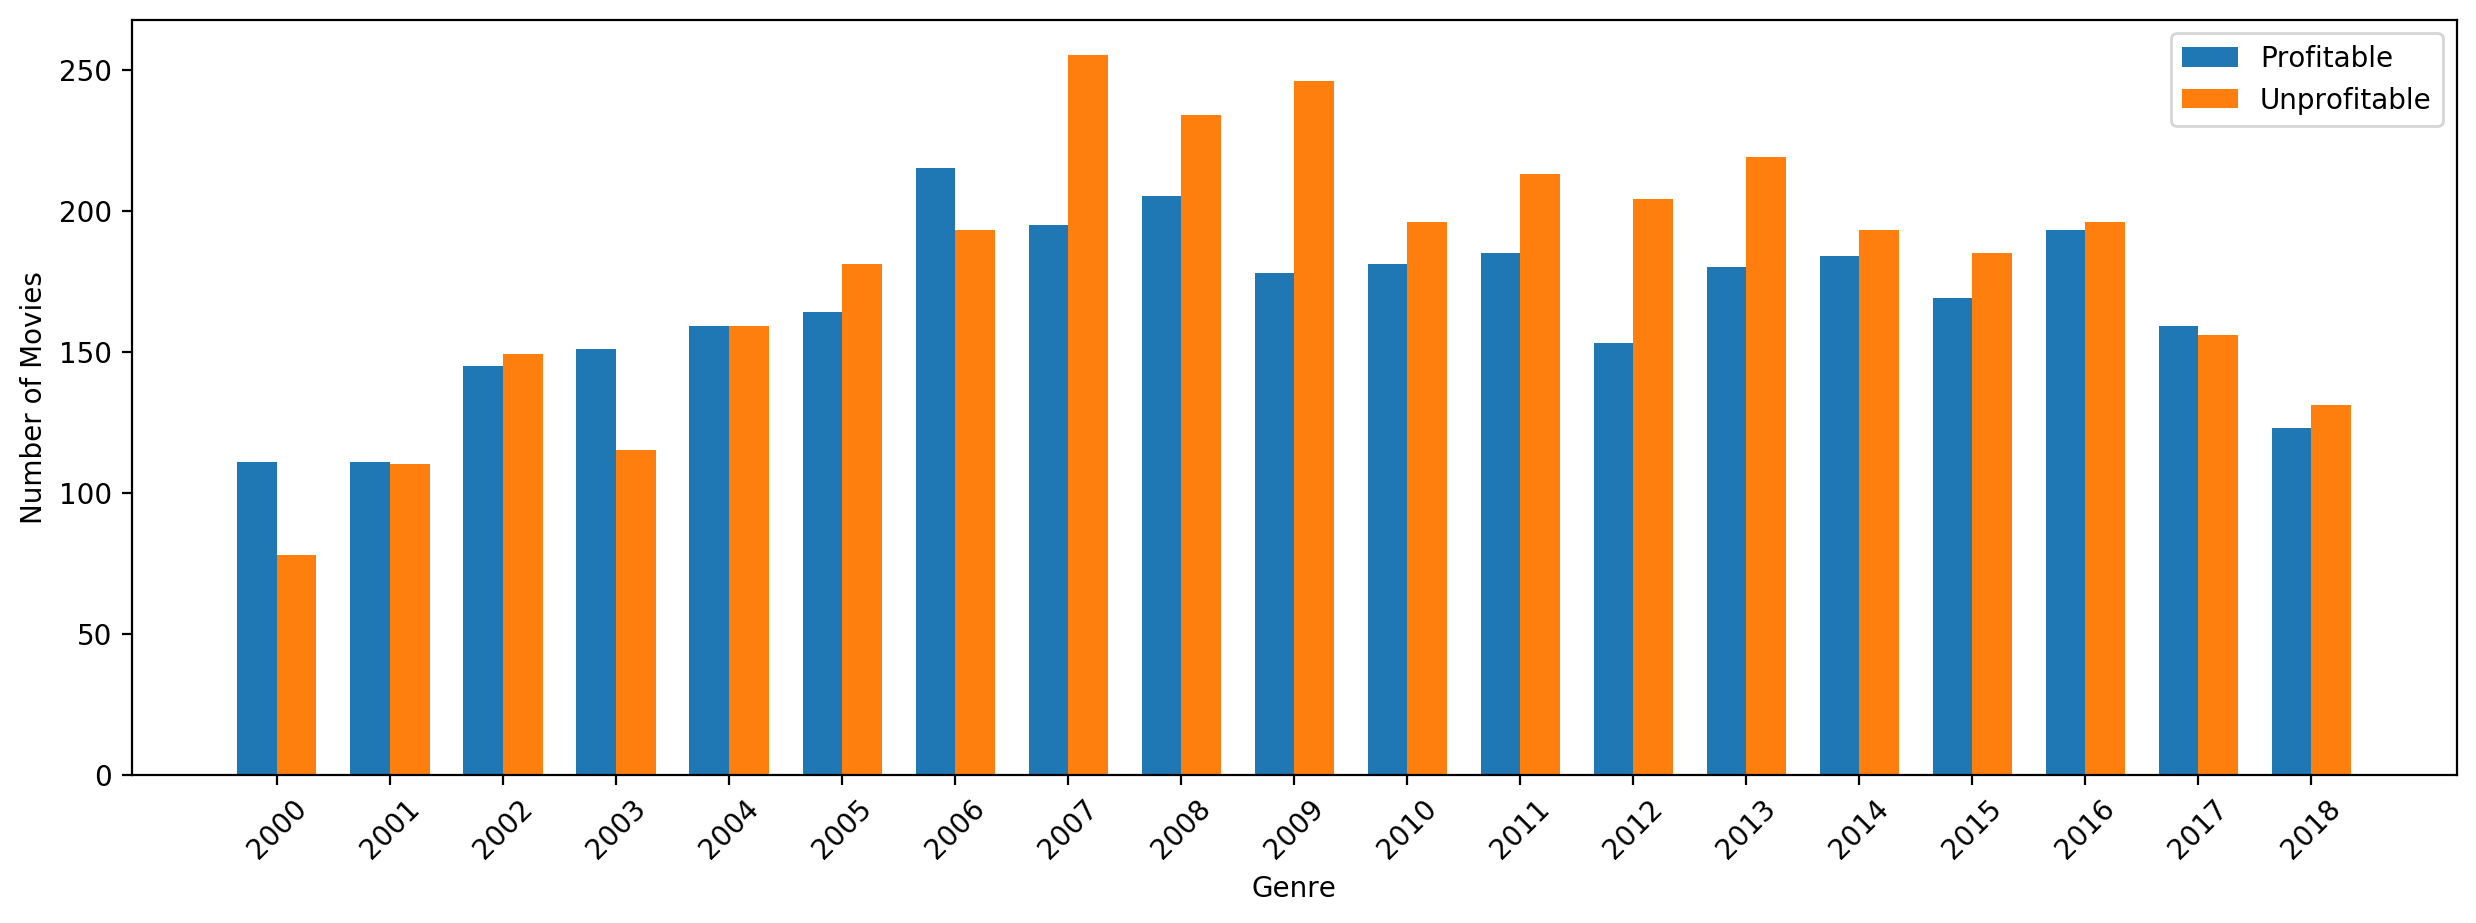

In [62]:
Year = np.arange(2000,2019)
year_group = {}
for each_year in Year:
    year_ratio_positive = imdb[imdb['startYear'] == each_year]['Profitable'].sum()
    year_num = (imdb['startYear'] == each_year).sum()
    year_ratio_negative = year_num - year_ratio_positive
    year_group[each_year] = (year_ratio_positive, year_ratio_negative)

x = np.arange(len(Year))
width = 0.35
plt.figure(dpi=200,figsize=(15,5))
plt.bar(x - width/2, [year_group.get(x)[0] for x in Year], width, label="Profitable")
plt.bar(x + width/2, [year_group.get(x)[1] for x in Year], width, label="Unprofitable")
plt.xticks(range(len(year_group)), year_group, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

### Run time and Rating

From the image below, we can see that the movies' time length may affect the average rating.

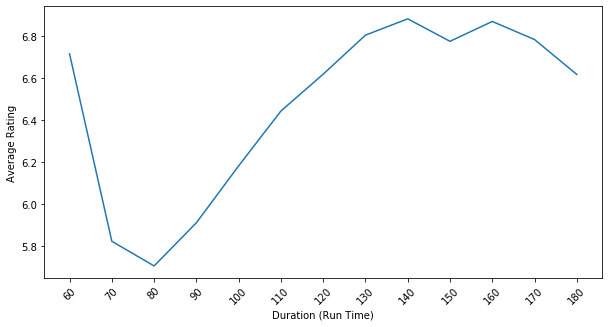

In [63]:
run_time_rating=[]
time_interval = 10
for run_time in range(60,181,time_interval):
    rating = imdb[(imdb['runtimeMinutes'] >= run_time) & (imdb['runtimeMinutes'] < run_time + time_interval)]['averageRating'].sum() 
    movie_num = ((imdb['runtimeMinutes'] >= run_time) & (imdb['runtimeMinutes'] < run_time + time_interval)).sum()
    rating /= movie_num
    run_time_rating.append(rating)

plt.figure(figsize=(10,5))
plt.plot(range(60,181,time_interval), run_time_rating)
plt.xticks(list(range(60,181,time_interval)), rotation=45)
plt.xlabel("Duration (Run Time)")
plt.ylabel("Average Rating")
plt.show()

## 3 - Baseline Models

### 3.1 Random Guessing
Through preprocessing, we find that the average rating distribution is centered near **6.0**. To predict a movie's rating, we first make a random guessing ...

### 3.2 Vanilla Multi Layer Perceptron
We first build a two-layer shallow neural network as a baseline for movie rating prediction. The input features are duration, year, budget and genre. Run the following cell to build the neural network first.

In [8]:
class Net(torch.nn.Module):  
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()     
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   
        self.predict = torch.nn.Linear(n_hidden, n_output)   

    def forward(self, x):   

        x = self.hidden(x)   
        x = self.predict(x)             
        return x

Load our pretrained model

In [9]:
path_mlp = '../model/VanillaMLP.pth'
checkpoint_mlp = torch.load(path_mlp)
model_mlp = Net(n_feature=26, n_hidden=10, n_output=1)
model_mlp.load_state_dict(checkpoint_mlp)

<All keys matched successfully>

Test model

In [10]:
x_test = torch.load('../data/x_test.pt')
y_test = torch.load('../data/y_test.pt')
mean = torch.load('../data/mean.pt')
std = torch.load('../data/std.pt')

for j in range(3):
    x_test[:, j] = (x_test[:,j] - mean[j]) / std[j]

model_mlp.eval()
loss_func = torch.nn.L1Loss()
with torch.no_grad():
        prediction_test = model_mlp(x_test)
        loss_test = loss_func(prediction_test, y_test)
        print("Mean Absolute Error of Test Dataset:"+str(float(loss_test)))

Mean Absolute Error of Test Dataset:0.7909643650054932


In [12]:
torch.load('../data/x_test.pt')

tensor([[3.0000e+05, 2.0020e+03, 9.5000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0000e+06, 2.0020e+03, 1.0600e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5000e+05, 2.0020e+03, 1.0500e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.5000e+07, 2.0050e+03, 1.2300e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+07, 2.0070e+03, 1.3500e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5000e+07, 2.0050e+03, 9.3000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

### 3.3 Convolutional Neural Network
We then build a two-layer ConvNet in Pytorch for movie rating prediction using only poster information. 

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential( # input shape (3, 200, 200)
            nn.Conv2d(
                in_channels=3,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      
            ),      
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(      # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),                   # activation
            nn.MaxPool2d(2),             # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 50 * 50, 1)   
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output

Load the pretrained CNN model

In [2]:
path_cnn = '../model/CNN.pth'
checkpoint_cnn = torch.load(path_cnn)
model_cnn = CNN()
model_cnn.load_state_dict(checkpoint_cnn)

<All keys matched successfully>

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, datatxt, transform=None):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r')
        imgs = []
        labels = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0]))
            labels.append(torch.FloatTensor([float(words[1])]))
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __getitem__(self,index):
        image_name = self.imgs[index]
        label = self.labels[index]
        img = Image.open(root+image_name)
        if self.transform is not None:
            img = self.transform(img)
        return img, label
        
    def __len__(self):
        return len(self.imgs)
    
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) ,
    ])
root = '../data/resize/'
test_data = MyDataset(root,'test.txt', transform=transform)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False)

Run the cell to test the pretrained CNN model for movie rating prediction

In [9]:
model_cnn.eval()
loss_func = torch.nn.L1Loss()
with torch.no_grad():
    for i, [x_test, y_test] in enumerate(test_loader):
        y_test = y_test.view(-1,1)
        prediction_test = model_cnn(x_test)    
        loss_test = loss_func(prediction_test, y_test)
        print('Test Loss for batch {}:'.format(i)+str(loss_test.item()))

Test Loss for batch 0:1.1698436737060547
Test Loss for batch 1:1.1251472234725952
Test Loss for batch 2:1.0614213943481445
Test Loss for batch 3:1.2211153507232666
Test Loss for batch 4:1.1187527179718018
Test Loss for batch 5:1.1800163984298706
Test Loss for batch 6:1.2485582828521729
Test Loss for batch 7:1.1964244842529297
Test Loss for batch 8:1.1133034229278564
Test Loss for batch 9:1.1681828498840332
Test Loss for batch 10:1.2927477359771729
Test Loss for batch 11:1.2411119937896729
Test Loss for batch 12:1.1287682056427002
Test Loss for batch 13:1.2126307487487793
Test Loss for batch 14:1.147301435470581
Test Loss for batch 15:1.0865519046783447


## 4 - Proposed Solutions

The proposed multimodel deep neural network for movie rating and box-office prediction is shown below. A CNN is constructed based on the structure of [ResNet18](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) to extract the poster feature. Movie genre, directors, actors and writers are input as one-hot vectors. Storylines are mapped to vectors using a embedding layer. The features of the text information are extracted using a LSTM. Other metadata like movie budget, duration and release year are used as numerical features for training.

<table>

<img src="images/model.png" style="width:1200;height:400px;">

</table>

In [3]:
from model import RatingModel
from torch.utils.data import DataLoader
from dataloader import IMDB
from lookuptable import LookupTable
from hyperparams import Hyperparams as hps
from tqdm import tqdm

In [2]:
def val(val_loader, model):

    model.eval() # disable dropout
    loss = 0
    predict_rating_group = []
    with torch.no_grad(): # save memory
        for (rating, attributes, actor, writer, director, genre, seq, seq_len, img, profitable_label) in tqdm(val_loader):

            predicted_rating = model(attributes, actor, writer, director, genre, seq, seq_len, img)
            
            predicted_rating = predicted_rating.squeeze(1).detach().cpu().numpy()
            rating = rating.squeeze(1).detach().cpu().numpy()
            loss += abs(predicted_rating - rating).sum()
            predict_rating_group.append(predicted_rating)

        print("Validation Result:{:.3f}".format(float(loss/(len(val_loader))/1)))
    return predict_rating_group

with open("../model/rating_model/lookuptable.pkl",'rb') as f:
    lookuptable = pickle.load(f)

model = RatingModel(lookuptable.cal_len('actor'),
                    lookuptable.cal_len('writer'),
                    lookuptable.cal_len('director'),
                    lookuptable.cal_len('genre'),
                    lookuptable.cal_len('word')
                    )

checkpoint = torch.load("../model/RatingModel.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['Model_state_dict'])
val_loader = DataLoader(IMDB("../data/val.tsv", lookuptable),
                        batch_size=1,
                        shuffle=False)

predict_rating_group = []
predict_rating_group = val(val_loader, model)

AttributeError: Can't get attribute 'LookupTable' on <module '__main__'>

In [4]:
from model import BoxOfficeModel

def val(val_loader, model):

    model.eval() # disable dropout

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    pre_profitable = []
    with torch.no_grad(): # save memory
        for (rating, attributes, actor, writer, director, genre, seq, seq_len, img, profitable_label) in tqdm(val_loader):

            profitable_label = profitable_label.squeeze(1)

            predicted_box_office = model(attributes, actor, writer, director, genre, seq, seq_len, img)
            _, index = torch.max(predicted_box_office, 1)

            index = index.detach().cpu().numpy()
            profitable_label = profitable_label.detach().cpu().numpy()

            for i in range(len(index)):
                if index[i] == 1 and profitable_label[i] == 1:
                    TP += 1
                elif index[i] == 1 and profitable_label[i] == 0:
                    FP +=1
                elif index[i] == 0 and profitable_label[i] == 1:
                    FN +=1
                elif index[i] == 0 and profitable_label[i] == 0:
                    TN +=1
            
                pre_profitable.append(index[i])

        pre = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1_Score = (2 * pre * recall) / (pre + recall)


    print("Pre: {:.3f} , Recall: {:.3f} , F1: {:.3f}".format(pre, recall, F1_Score))
    return pre_profitable

with open("../model/rating_model/lookuptable.pkl",'rb') as f:
    lookuptable = pickle.load(f)

model = BoxOfficeModel(
    lookuptable.cal_len('actor'),
    lookuptable.cal_len('writer'),
    lookuptable.cal_len('director'),
    lookuptable.cal_len('genre'),
    lookuptable.cal_len('word')
    )

val_loader = DataLoader(IMDB("../data/val.tsv", lookuptable),
                        batch_size=16,
                        shuffle=False)
checkpoint = torch.load("../model/BoxOfficeModel.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['Model_state_dict'])

pre_profitable = []
pre_profitable = val(val_loader, model)

100%|██████████| 83/83 [01:47<00:00,  1.29s/it]

Pre: 0.877 , Recall: 0.868 , F1: 0.872


## 5 - Results Analysis

### 5.1 The Distribution of Groud truth and Prediction on Movies' Rating

Most of our prediction locate on 6.3. It is because our dataset is unbalanced. Most of our movies' ratings are 5 to 7. So the trained model is hard to tell which movie is "very bad" like 3.0 or "very good" like 8.0.

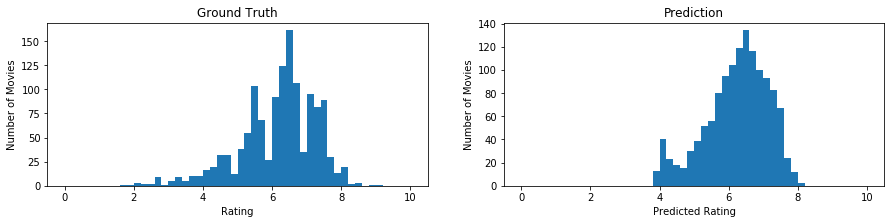

In [7]:
val = pd.read_csv("../data/val.tsv", sep='\t', index_col=0)
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(val['averageRating'], bins=50, range=(0,10))
plt.title("Ground Truth")
plt.xlabel("Rating")
plt.ylabel("Number of Movies")

predict_val = []
for rating in predict_rating_group:
    rating = rating[0]
    predict_val.append(rating)
val['predicted_rating'] = predict_val

plt.subplot(122)
plt.hist(val['predicted_rating'], bins=50, range=(0,10))
plt.title("Prediction")
plt.xlabel("Predicted Rating")
plt.ylabel("Number of Movies")
plt.show()

In [8]:
val.to_csv("../data/val_with_predicted_rating.tsv",sep='\t')
val = pd.read_csv("../data/val_with_predicted_rating.tsv",sep='\t',index_col=0)

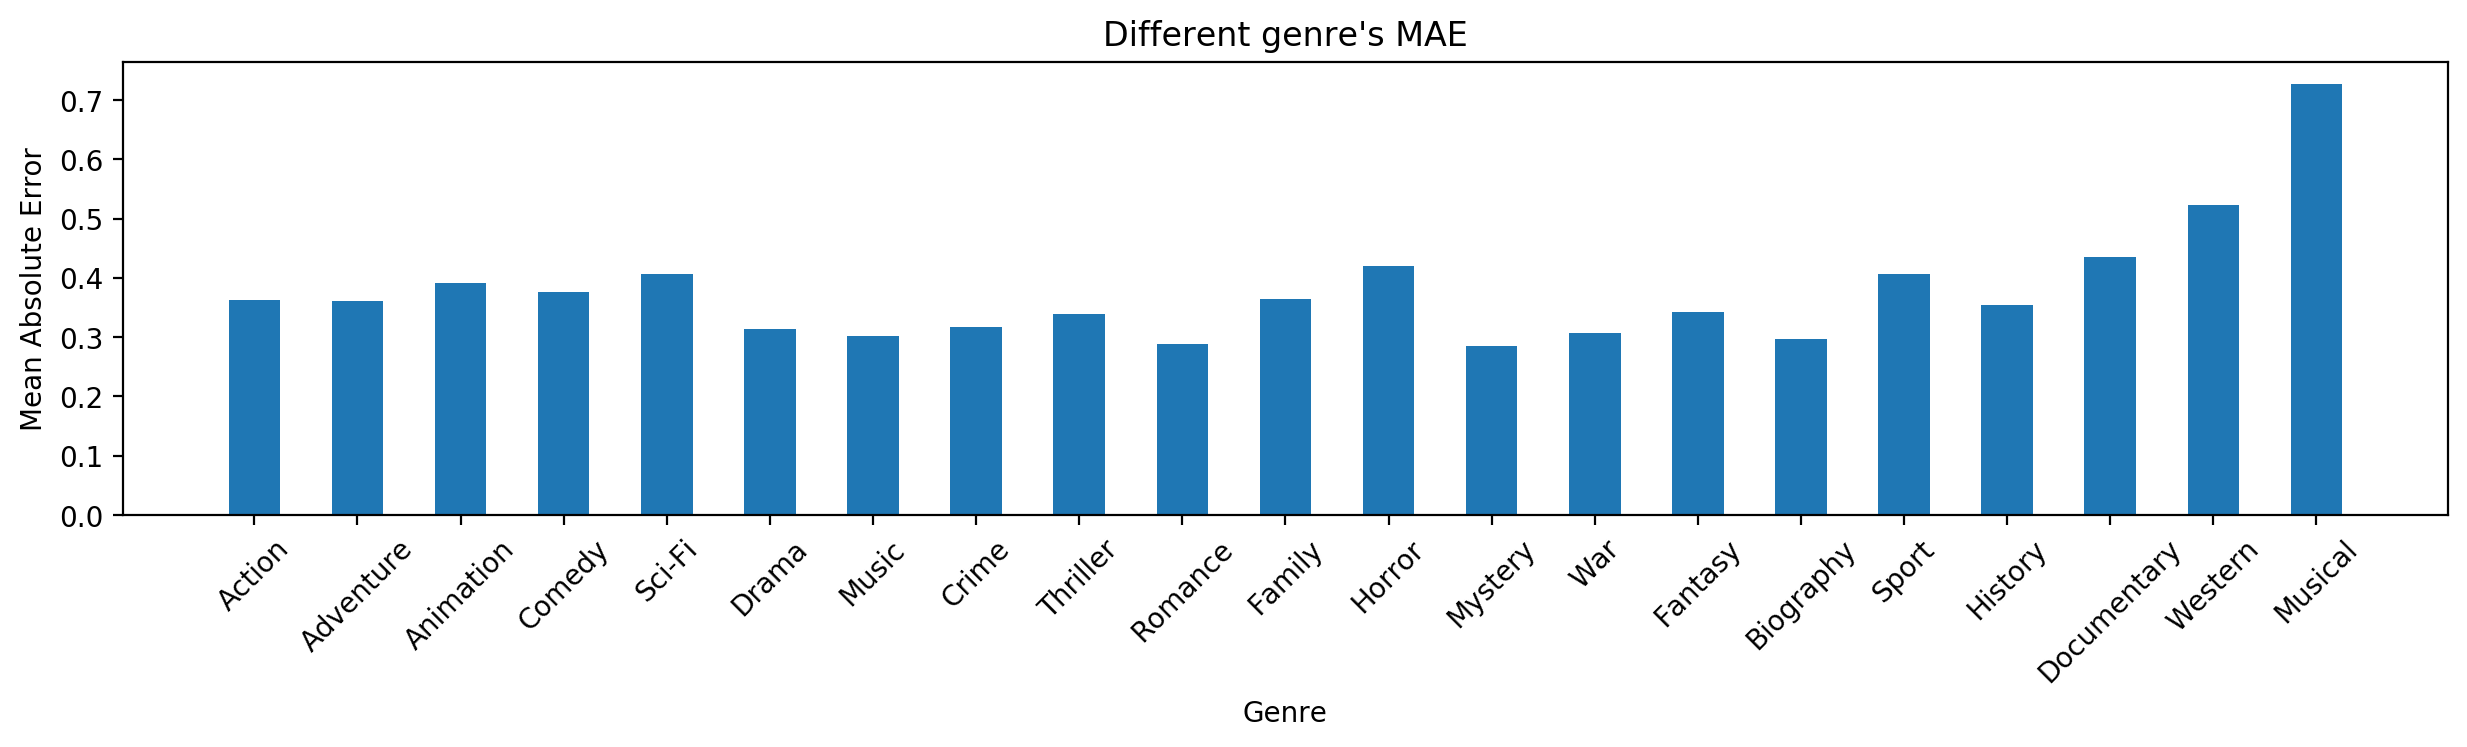

In [9]:
genres = {}
for row in val.iterrows():
    rating = row[1]['averageRating']
    pre_rating = row[1]['predicted_rating']
    for genre in row[1]['genres'].split(','):
        if genre == '\\N':
            continue
        try:
            genres[genre][0] += abs(rating - pre_rating)
            genres[genre][1] += 1
        except KeyError:
            genres[genre] = [abs(rating - pre_rating),1]

plt.figure(figsize=(15,3), dpi=200)
x = np.arange(len(genres))
width = 0.5
plt.bar(x, [(genres[k][0]/genres[k][1]) for k in genres], width)
plt.xticks(range(len(genres)), genres, rotation=45)
plt.title("Different genre's MAE")
plt.xlabel("Genre")
plt.ylabel("Mean Absolute Error")
plt.show()

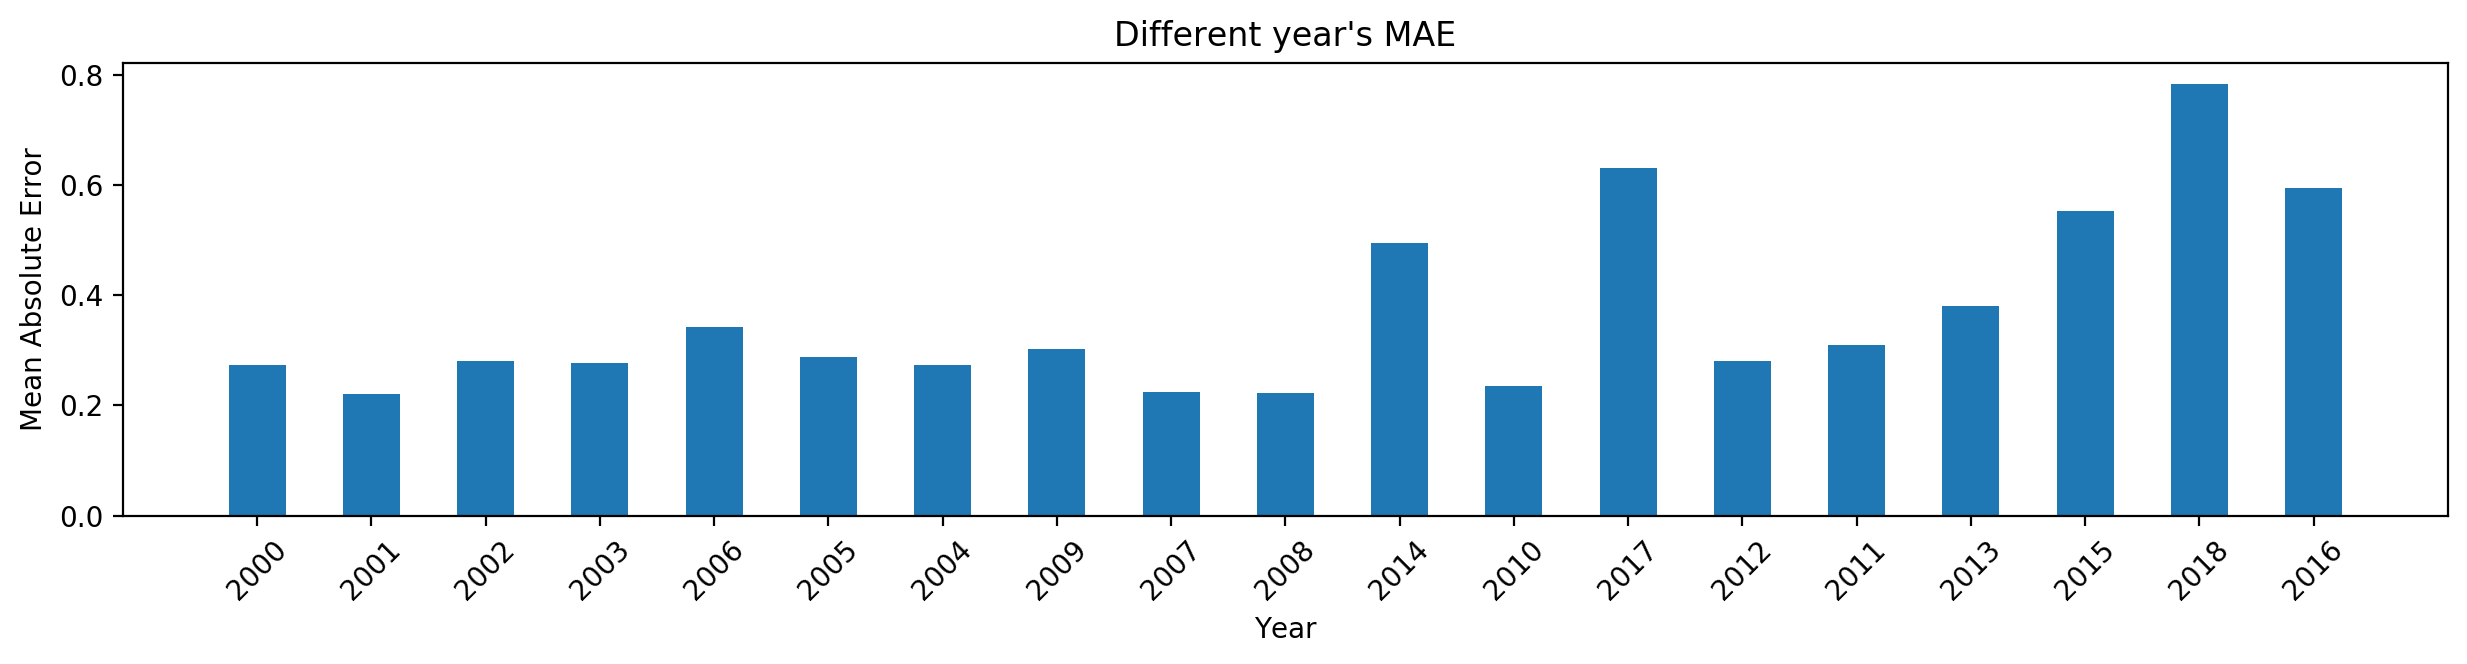

In [10]:
years = {}
for row in val.iterrows():
    rating = row[1]['averageRating']
    pre_rating = row[1]['predicted_rating']
    year = int(row[1]['startYear'])
    try:
        years[year][0] += abs(rating - pre_rating)
        years[year][1] += 1
    except KeyError:
        years[year] = [abs(rating - pre_rating),1]

plt.figure(figsize=(15,3), dpi=200)
x = np.arange(len(years))
width = 0.5
plt.bar(x, [(years[k][0]/years[k][1]) for k in years], width)
plt.xticks(range(len(years)), years, rotation=45)
plt.title("Different year's MAE")
plt.xlabel("Year")
plt.ylabel("Mean Absolute Error")
plt.show()